In [8]:
import pandas as pd
from pathlib import Path
from sqlalchemy.engine import create_engine

import dbcp

/app/.local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [6]:
pudl_path = Path('../data/data_cache/pudl-v0.5.0-2021-11-14/pudl_data/sqlite/pudl.sqlite')
assert pudl_path.exists()
pudl_engine = create_engine(f"sqlite:///{pudl_path}")

In [9]:
postgres_engine = dbcp.helpers.get_sql_engine()

# Compare MCOE to EIA923 generation_fuel
`generation_fuel` has much better coverage of small plants (including ALL gas turbines!!!)

In [14]:
mcoe_query = """
select
    plant_id_eia,
    SUM(net_generation_mwh) as mwh,
    SUM(capacity_mw) as mw,
    SUM(total_mmbtu) as mmbtu
from data_warehouse.mcoe
where operational_status = 'existing'
GROUP BY 1
ORDER BY 1
"""
mcoe = pd.read_sql(mcoe_query, postgres_engine)

In [16]:
mcoe.describe()

,plant_id_eia,mwh,mw,mmbtu
count,10494.000000,1.024300e+04,10494.000000,1.150000e+03
mean,44479.717076,3.108996e+05,115.511654,1.770436e+07
std,24366.749822,1.160349e+06,332.788786,2.298634e+07
min,1.000000,-8.454800e+05,0.400000,0.000000e+00
25%,10501.500000,2.569500e+03,2.400000,2.594095e+06
50%,57613.500000,9.744000e+03,7.450000,9.023130e+06
75%,60755.750000,1.023405e+05,61.100000,2.432235e+07
max,64837.000000,2.029017e+07,6809.000000,1.740624e+08


In [18]:
genfuel_query = """
select
    plant_id_eia,
    SUM(net_generation_mwh) as mwh,
    SUM(fuel_consumed_for_electricity_mmbtu) as mmbtu
from generation_fuel_eia923
where report_date >= date('2020-01-01') -- this is monthly data
GROUP BY 1
ORDER BY 1
"""
genfuel = pd.read_sql(genfuel_query, pudl_engine)

In [19]:
genfuel.describe()

,plant_id_eia,mwh,mmbtu
count,10415.000000,1.041500e+04,1.041500e+04
mean,44467.656937,3.085299e+05,2.680953e+06
std,24326.798537,1.154703e+06,1.006033e+07
min,1.000000,-8.454800e+05,0.000000e+00
25%,10503.500000,2.429500e+03,2.240100e+04
50%,57589.000000,9.486000e+03,8.528300e+04
75%,60714.500000,1.007830e+05,9.166795e+05
max,64756.000000,2.029017e+07,1.778858e+08


## Compare only fossil plants
`generation_fuel` has full coverage of net generation and fuel burn (by count, should check that monthly availability matches)

In [20]:
mcoe_query = """
select
    plant_id_eia,
    SUM(net_generation_mwh) as mwh,
    SUM(capacity_mw) as mw,
    SUM(total_mmbtu) as mmbtu
from data_warehouse.mcoe
where operational_status = 'existing'
AND fuel_type_code_pudl in ('coal', 'gas', 'oil')
GROUP BY 1
ORDER BY 1
"""
mcoe = pd.read_sql(mcoe_query, postgres_engine)

In [21]:
mcoe.describe()

,plant_id_eia,mwh,mw,mmbtu
count,3012.000000,2.908000e+03,3012.000000,9.230000e+02
mean,31378.449867,8.221375e+05,272.389309,2.030010e+07
std,26358.808568,1.959528e+06,485.560968,2.478181e+07
min,1.000000,-1.273060e+05,0.300000,0.000000e+00
25%,3452.750000,2.037500e+02,6.000000,3.044716e+06
50%,50301.500000,2.078450e+04,40.000000,1.128809e+07
75%,56191.000000,4.361000e+05,335.800000,2.844860e+07
max,64816.000000,1.976452e+07,4263.000000,1.740624e+08


In [22]:
genfuel_query = """
select
    plant_id_eia,
    SUM(net_generation_mwh) as mwh,
    SUM(fuel_consumed_for_electricity_mmbtu) as mmbtu
from generation_fuel_eia923
where report_date >= date('2020-01-01') -- this is monthly data
AND fuel_type_code_pudl in ('coal', 'gas', 'oil')
GROUP BY 1
ORDER BY 1
"""
genfuel = pd.read_sql(genfuel_query, pudl_engine)

In [23]:
genfuel.describe()

,plant_id_eia,mwh,mmbtu
count,3323.000000,3.323000e+03,3.323000e+03
mean,31636.423714,7.292466e+05,6.248634e+06
std,25943.235585,1.856886e+06,1.618872e+07
min,3.000000,-1.967550e+05,0.000000e+00
25%,3991.500000,1.270000e+02,2.376500e+03
50%,50296.000000,1.561635e+04,1.406650e+05
75%,56085.000000,2.884787e+05,2.647332e+06
max,64756.000000,1.976452e+07,1.740624e+08


## Check monthly data coverage: mwh vs mmbtu

In [43]:
query = """
select
    COUNT(*) as n,    
    COUNT(net_generation_mwh) as n_mwh,
    COUNT(fuel_consumed_for_electricity_mmbtu) as n_mmbtu
from generation_fuel_eia923
where report_date >= date('2020-01-01') -- this is monthly data
AND fuel_type_code_pudl in ('coal', 'gas', 'oil')
"""
pd.read_sql(query, pudl_engine)

,n,n_mwh,n_mmbtu
0,79793,79793,79793


In [53]:
query = """
select
    COUNT(*) as n,    
    SUM(net_generation_mwh > 0) as n_mwh,
    SUM(fuel_consumed_for_electricity_mmbtu > 0) as n_mmbtu
from generation_fuel_eia923
where report_date >= date('2020-01-01') -- this is monthly data
AND fuel_type_code_pudl in ('coal', 'gas', 'oil')
"""
pd.read_sql(query, pudl_engine)

,n,n_mwh,n_mmbtu
0,79793,50142,49917


SQLite doesn't have XOR, so I have to emulate one

In [49]:
xor_test = pd.DataFrame({'a': [True, False, True, False], 'b': [True, True, False, False]}).astype(int)
xor_test['xor'] = xor_test['a'] ^ xor_test['b']
xor_test['xor_emulated'] = (xor_test['a'] | xor_test['b']) & ~(xor_test['a'] & xor_test['b'])
assert xor_test['xor'].eq(xor_test['xor_emulated']).all()
xor_test

,a,b,xor,xor_emulated
0,1,1,0,0
1,0,1,1,1
2,1,0,1,1
3,0,0,0,0


In [57]:
# this XOR doesn't match the truth table below and I have no idea why
# It really bothers me! But I can't bill the client for debugging that doesn't matter :(
query = """
select
    COUNT(*) as n,    
    SUM(
            (
                (net_generation_mwh > 0) OR (fuel_consumed_for_electricity_mmbtu > 0)
            ) AND NOT
            (
                (net_generation_mwh > 0) AND (fuel_consumed_for_electricity_mmbtu > 0)
            )
        ) as n_xor
from generation_fuel_eia923
where report_date >= date('2020-01-01') -- this is monthly data
AND fuel_type_code_pudl in ('coal', 'gas', 'oil')
"""
pd.read_sql(query, pudl_engine)

,n,n_xor
0,79793,5181


In [58]:
query = """
select
    COUNT(*) as n,    
    SUM((net_generation_mwh > 0) AND (fuel_consumed_for_electricity_mmbtu > 0)) as both,
    SUM((net_generation_mwh = 0) AND (fuel_consumed_for_electricity_mmbtu = 0)) as neither,
    SUM((net_generation_mwh > 0) AND (fuel_consumed_for_electricity_mmbtu = 0)) as mwh_no_btu,
    SUM((net_generation_mwh = 0) AND (fuel_consumed_for_electricity_mmbtu > 0)) as btu_no_mwh,
    net_generation_mwh is NULL as null_mwh,
    fuel_consumed_for_electricity_mmbtu is NULL as null_mmbtu
from generation_fuel_eia923
where report_date >= date('2020-01-01') -- this is monthly data
AND fuel_type_code_pudl in ('coal', 'gas', 'oil')
"""
pd.read_sql(query, pudl_engine)

,n,both,neither,mwh_no_btu,btu_no_mwh,null_mwh,null_mmbtu
0,79793,47439,26182,2703,708,0,0


# Calc CO2
Make two estimates: one from fuel data, one from electricity data + assumed heat rate. Where there is a big difference, I might use the larger one?

In [25]:
import numpy as np

In [29]:
# definition of fuel_type_code_pudl from src/pudl/metadata/codes.py
pd.DataFrame(
        columns=[
            "code",
            "label",
            "fuel_units",
            "min_fuel_mmbtu_per_unit",
            "max_fuel_mmbtu_per_unit",
            "fuel_group_eia",
            "fuel_derived_from",
            "fuel_phase",
            "fuel_type_code_pudl",
            "description",
        ],
        data=[
            (
                "AB",
                "agricultural_byproducts",
                "short_tons",
                7.0,
                18.0,
                "renewable",
                "biomass",
                "solid",
                "waste",
                "Agricultural by-products",
            ),
            (
                "ANT",
                "anthracite",
                "short_tons",
                22.0,
                28.0,
                "fossil",
                "coal",
                "solid",
                "coal",
                "Anthracite coal",
            ),
            (
                "BFG",
                "blast_furnace_gas",
                "mcf",
                0.07,
                0.12,
                "fossil",
                "gas",
                "gas",
                "gas",
                "Blast furnace gas",
            ),
            (
                "BIT",
                "bituminous_coal",
                "short_tons",
                20.0,
                29.0,
                "fossil",
                "coal",
                "solid",
                "coal",
                "Bituminous coal",
            ),
            (
                "BLQ",
                "black_liquor",
                "short_tons",
                10.0,
                14.0,
                "renewable",
                "biomass",
                "liquid",
                "waste",
                "Black liquor",
            ),
            (
                "DFO",
                "distillate_fuel_oil",
                "barrels",
                5.5,
                6.2,
                "fossil",
                "petroleum",
                "liquid",
                "oil",
                "Distillate fuel oil, including diesel, No. 1, No. 2, and No. 4 fuel oils",
            ),
            (
                "GEO",
                "geothermal",
                pd.NA,
                np.nan,
                np.nan,
                "renewable",
                "other",
                pd.NA,
                "other",
                "Geothermal",
            ),
            (
                "JF",
                "jet_fuel",
                "barrels",
                5.0,
                6.0,
                "fossil",
                "petroleum",
                "liquid",
                "oil",
                "Jet fuel",
            ),
            (
                "KER",
                "kerosene",
                "barrels",
                5.6,
                6.1,
                "fossil",
                "petroleum",
                "liquid",
                "oil",
                "Kerosene",
            ),
            (
                "LFG",
                "landfill_gas",
                "mcf",
                0.3,
                0.6,
                "renewable",
                "biomass",
                "gas",
                "waste",
                "Landfill gas",
            ),
            (
                "LIG",
                "lignite",
                "short_tons",
                10.0,
                14.5,
                "fossil",
                "coal",
                "solid",
                "coal",
                "Lignite coal",
            ),
            (
                "MSB",
                "municipal_solid_waste_biogenic",
                "short_tons",
                9.0,
                12.0,
                "renewable",
                "biomass",
                "solid",
                "waste",
                "Municipal solid waste (biogenic)",
            ),
            (
                "MSN",
                "municipal_solid_nonbiogenic",
                "short_tons",
                9.0,
                12.0,
                "fossil",
                "petroleum",
                "solid",
                "waste",
                "Municipal solid waste (non-biogenic)",
            ),
            (
                "MSW",
                "municipal_solid_waste",
                "short_tons",
                9.0,
                12.0,
                "renewable",
                "biomass",
                "solid",
                "waste",
                "Municipal solid waste (all types)",
            ),
            (
                "MWH",
                "electricity_storage",
                "mwh",
                np.nan,
                np.nan,
                "other",
                "other",
                pd.NA,
                "other",
                "Electricity used for electricity storage",
            ),
            (
                "NG",
                "natural_gas",
                "mcf",
                0.8,
                1.1,
                "fossil",
                "gas",
                "gas",
                "gas",
                "Natural gas",
            ),
            (
                "NUC",
                "nuclear",
                pd.NA,
                np.nan,
                np.nan,
                "other",
                "other",
                pd.NA,
                "nuclear",
                "Nuclear, including uranium, plutonium, and thorium",
            ),
            (
                "OBG",
                "other_biomass_gas",
                "mcf",
                0.36,
                1.6,
                "renewable",
                "biomass",
                "gas",
                "waste",
                "Other biomass gas, including digester gas, methane, and other biomass gasses",
            ),
            (
                "OBL",
                "other_biomass_liquid",
                "barrels",
                3.5,
                4.0,
                "renewable",
                "biomass",
                "liquid",
                "waste",
                "Other biomass liquids",
            ),
            (
                "OBS",
                "other_biomass_solid",
                "short_tons",
                8.0,
                25.0,
                "renewable",
                "biomass",
                "solid",
                "waste",
                "Other biomass solids",
            ),
            (
                "OG",
                "other_gas",
                "mcf",
                0.32,
                3.3,
                "fossil",
                "other",
                "gas",
                "gas",
                "Other gas",
            ),
            (
                "OTH",
                "other",
                pd.NA,
                np.nan,
                np.nan,
                "other",
                "other",
                pd.NA,
                "other",
                "Other",
            ),
            (
                "PC",
                "petroleum_coke",
                "short_tons",
                24.0,
                30.0,
                "fossil",
                "petroleum",
                "solid",
                "coal",
                "Petroleum coke",
            ),
            (
                "PG",
                "propane_gas",
                "mcf",
                2.5,
                2.75,
                "fossil",
                "petroleum",
                "gas",
                "gas",
                "Gaseous propane",
            ),
            (
                "PUR",
                "purchased_steam",
                pd.NA,
                np.nan,
                np.nan,
                "other",
                "other",
                pd.NA,
                "other",
                "Purchased steam",
            ),
            (
                "RC",
                "refined_coal",
                "short_tons",
                20.0,
                29.0,
                "fossil",
                "coal",
                "solid",
                "coal",
                "Refined coal",
            ),
            (
                "RFO",
                "residual_fuel_oil",
                "barrels",
                5.7,
                6.9,
                "fossil",
                "petroleum",
                "liquid",
                "oil",
                "Residual fuel oil, including Nos. 5 & 6 fuel oils and bunker C fuel oil",
            ),
            (
                "SC",
                "coal_synfuel",
                "short_tons",
                np.nan,
                np.nan,
                "fossil",
                "coal",
                "solid",
                "coal",
                "Coal synfuel. Coal-based solid fuel that has been processed by a coal synfuel plant, and coal-based fuels such as briquettes, pellets, or extrusions, which are formed from fresh or recycled coal and binding materials.",
            ),
            (
                "SG",
                "syngas_other",
                "mcf",
                np.nan,
                np.nan,
                "fossil",
                "other",
                "gas",
                "gas",
                "Synthetic gas, other than coal-derived",
            ),
            (
                "SGC",
                "syngas_coal",
                "mcf",
                0.2,
                0.3,
                "fossil",
                "coal",
                "gas",
                "gas",
                "Coal-derived synthesis gas",
            ),
            (
                "SGP",
                "syngas_petroleum_coke",
                "mcf",
                0.2,
                1.1,
                "fossil",
                "petroleum",
                "gas",
                "gas",
                "Synthesis gas from petroleum coke",
            ),
            (
                "SLW",
                "sludge_waste",
                "short_tons",
                10.0,
                16.0,
                "renewable",
                "biomass",
                "liquid",
                "waste",
                "Sludge waste",
            ),
            (
                "SUB",
                "subbituminous_coal",
                "short_tons",
                15.0,
                20.0,
                "fossil",
                "coal",
                "solid",
                "coal",
                "Sub-bituminous coal",
            ),
            (
                "SUN",
                "solar",
                pd.NA,
                np.nan,
                np.nan,
                "renewable",
                "other",
                pd.NA,
                "solar",
                "Solar",
            ),
            (
                "TDF",
                "tire_derived_fuels",
                "short_tons",
                16.0,
                32.0,
                "other",
                "other",
                "solid",
                "waste",
                "Tire-derived fuels",
            ),
            (
                "WAT",
                "water",
                pd.NA,
                np.nan,
                np.nan,
                "renewable",
                "other",
                pd.NA,
                "hydro",
                "Water at a conventional hydroelectric turbine, and water used in wave buoy hydrokinetic technology, current hydrokinetic technology, and tidal hydrokinetic technology, or pumping energy for reversible (pumped storage) hydroelectric turbine",
            ),
            (
                "WC",
                "waste_coal",
                "short_tons",
                6.5,
                16.0,
                "fossil",
                "coal",
                "solid",
                "coal",
                "Waste/Other coal, including anthracite culm, bituminous gob, fine coal, lignite waste, waste coal.",
            ),
            (
                "WDL",
                "wood_liquids",
                "barrels",
                8.0,
                14.0,
                "renewable",
                "biomass",
                "liquid",
                "waste",
                "Wood waste liquids excluding black liquor, including red liquor, sludge wood, spent sulfite liquor, and other wood-based liquids",
            ),
            (
                "WDS",
                "wood_solids",
                "short_tons",
                7.0,
                18.0,
                "renewable",
                "biomass",
                "solid",
                "waste",
                "Wood/Wood waste solids, including paper pellets, railroad ties, utility poles, wood chips, park, and wood waste solids",
            ),
            (
                "WH",
                "waste_heat",
                pd.NA,
                np.nan,
                np.nan,
                "other",
                "other",
                pd.NA,
                "other",
                "Waste heat not directly attributed to a fuel source. WH should only be reported when the fuel source is undetermined, and for combined cycle steam turbines that do not have supplemental firing.",
            ),
            (
                "WND",
                "wind",
                pd.NA,
                np.nan,
                np.nan,
                "renewable",
                "other",
                pd.NA,
                "wind",
                "Wind",
            ),
            (
                "WO",
                "waste_oil",
                "barrels",
                3.0,
                5.8,
                "fossil",
                "petroleum",
                "liquid",
                "oil",
                "Waste/Other oil, including crude oil, liquid butane, liquid propane, naptha, oil waste, re-refined motor oil, sludge oil, tar oil, or other petroleum-based liquid wastes",
            ),
        ],
    )[['code', 'fuel_type_code_pudl', 'description']].sort_values('fuel_type_code_pudl')

,code,fuel_type_code_pudl,description
22,PC,coal,Petroleum coke
1,ANT,coal,Anthracite coal
3,BIT,coal,Bituminous coal
36,WC,coal,"Waste/Other coal, including anthracite culm, b..."
32,SUB,coal,Sub-bituminous coal
25,RC,coal,Refined coal
27,SC,coal,Coal synfuel. Coal-based solid fuel that has b...
10,LIG,coal,Lignite coal
15,NG,gas,Natural gas
23,PG,gas,Gaseous propane


In [80]:
query = """
select
    plant_id_eia,
    fuel_type_code_pudl,
    prime_mover_code,
    report_date,
    net_generation_mwh as mwh,
    fuel_consumed_for_electricity_mmbtu as mmbtu
from generation_fuel_eia923
where report_date >= date('2020-01-01') -- this is monthly data
AND fuel_type_code_pudl in ('coal', 'gas', 'oil')
ORDER BY 1, 2, 3, 4
"""
co2 = pd.read_sql(query, pudl_engine)

In [81]:
co2['heat_rate'] = co2['mmbtu'] / co2['mwh']

In [82]:
co2.head()

,plant_id_eia,fuel_type_code_pudl,prime_mover_code,report_date,mwh,mmbtu,heat_rate
0,3,coal,ST,2020-02-01,-152.343,1344.0,-8.822197
1,3,coal,ST,2020-02-01,0.000,0.0,NaN
2,3,coal,ST,2020-03-01,71190.754,748878.0,10.519315
3,3,coal,ST,2020-03-01,0.000,0.0,NaN
4,3,coal,ST,2020-04-01,266681.480,2673981.0,10.026872


In [83]:
co2.sample(10)

,plant_id_eia,fuel_type_code_pudl,prime_mover_code,report_date,mwh,mmbtu,heat_rate
32844,7760,gas,GT,2020-09-01,7275.284,77467.0,10.647969
61925,55404,gas,CA,2020-09-01,54386.000,90465.0,1.663388
76683,60345,gas,CA,2020-07-01,387011.000,0.0,0.000000
45649,50397,oil,ST,2020-01-01,56.504,319.0,5.645618
35120,7981,gas,GT,2020-06-01,5476.465,74281.0,13.563677
61370,55349,gas,GT,2020-07-01,235616.000,2446253.0,10.382372
42211,10773,gas,ST,2020-04-01,79.380,1270.0,15.998992
46988,50561,oil,CT,2020-02-01,0.000,0.0,NaN
1423,260,gas,CT,2020-02-01,313383.000,3349614.0,10.688563
79606,63922,gas,ST,2020-03-01,1423.239,16688.0,11.725367


In [84]:
# see distinct combos
combos = co2.groupby(['fuel_type_code_pudl', 'prime_mover_code'], as_index=False).agg({'plant_id_eia': 'nunique', 'mwh': 'sum', 'mmbtu': 'sum'}).sort_values('fuel_type_code_pudl')
combos['heat_rate'] = combos['mmbtu'] / combos['mwh']
combos

,fuel_type_code_pudl,prime_mover_code,plant_id_eia,mwh,mmbtu,heat_rate
0,coal,CA,2,3.947852e+05,9.112592e+06,23.082405
1,coal,CT,12,0.000000e+00,0.000000e+00,NaN
2,coal,GT,32,0.000000e+00,0.000000e+00,NaN
3,coal,IC,7,0.000000e+00,0.000000e+00,NaN
4,coal,OT,2,4.290698e+04,1.620170e+05,3.776006
5,coal,ST,485,7.772861e+08,8.265075e+09,10.633247
14,gas,ST,686,1.151784e+08,1.189699e+09,10.329185
13,gas,OT,6,8.279700e+04,0.000000e+00,0.000000
12,gas,IC,453,6.905756e+06,6.224132e+07,9.012962
11,gas,GT,915,1.336494e+08,1.268448e+09,9.490858


In [86]:
def combine_cc_parts(df):
    # split, apply, combine
    # split
    is_cc = df.loc[:, 'prime_mover_code'].isin({'CA', 'CT',})
    cc = df.loc[is_cc, :]
    # apply
    cc = cc.groupby(['plant_id_eia', 'report_date', 'fuel_type_code_pudl'], as_index=False).sum()
    cc['prime_mover_code'] = 'CC'
    # combine
    non_cc = df.loc[~is_cc,:]
    out = pd.concat([cc, non_cc], axis=0, ignore_index=True)
    return out

In [91]:
co2_cc = combine_cc_parts(co2)

In [92]:
# see distinct combos
combos_cc = co2_cc.groupby(['fuel_type_code_pudl', 'prime_mover_code'], as_index=False).agg({'plant_id_eia': 'nunique', 'mwh': 'sum', 'mmbtu': 'sum'}).sort_values('fuel_type_code_pudl')
combos_cc['heat_rate'] = combos_cc['mmbtu'] / combos_cc['mwh']
combos_cc

,fuel_type_code_pudl,prime_mover_code,plant_id_eia,mwh,mmbtu,heat_rate
0,coal,CC,12,3.947852e+05,9.112592e+06,23.082405
1,coal,GT,32,0.000000e+00,0.000000e+00,NaN
2,coal,IC,7,0.000000e+00,0.000000e+00,NaN
3,coal,OT,2,4.290698e+04,1.620170e+05,3.776006
4,coal,ST,485,7.772861e+08,8.265075e+09,10.633247
12,gas,ST,686,1.151784e+08,1.189699e+09,10.329185
11,gas,OT,6,8.279700e+04,0.000000e+00,0.000000
10,gas,IC,453,6.905756e+06,6.224132e+07,9.012962
9,gas,GT,915,1.336494e+08,1.268448e+09,9.490858
8,gas,FC,114,1.631943e+06,1.171512e+07,7.178633


In [93]:
from typing import Optional, Dict
def co2_from_mmbtu(df: pd.DataFrame, output_name: str = 'co2e_tonnes_via_mmbtu', mmbtu_col: str='mmbtu', fuel_co2_intensity: Optional[Dict[str, float]]=None) -> None:
    if fuel_co2_intensity is None:
        fuel_co2_intensity = {
            "gas": 53.06,
            "coal": 95.52,  # power sector average
            "oil": 73.96,  # DFO #2
        }
    df["tonnes_co2_per_mmbtu"] = df.loc[:, "fuel_type_code_pudl"].map(fuel_co2_intensity) / 1000
    df[output_name] = df.loc[:, mmbtu_col] * df.loc[:, "tonnes_co2_per_mmbtu"]
    df.drop(columns=['tonnes_co2_per_mmbtu'], inplace=True)
    return

In [94]:
co2_from_mmbtu(co2_cc)
co2_cc.head()

,plant_id_eia,report_date,fuel_type_code_pudl,mwh,mmbtu,heat_rate,prime_mover_code,co2e_tonnes_via_mmbtu
0,3,2020-02-01,gas,724086.0,5025753.0,10.698138,CC,266666.45418
1,3,2020-03-01,gas,740035.0,5175773.0,11.003474,CC,274626.51538
2,3,2020-04-01,gas,629248.0,4386420.0,10.741825,CC,232743.44520
3,3,2020-05-01,gas,581835.0,4091628.0,10.766268,CC,217101.78168
4,3,2020-06-01,gas,745083.0,5395849.0,11.342472,CC,286303.74794


In [95]:
def co2_from_mwh(df: pd.DataFrame, output_name: str = 'co2e_tonnes_via_mwh', mwh_col: str='mwh', heat_rates_mmbtu_per_mwh: Optional[Dict[str, float]]=None, fuel_co2_intensity: Optional[Dict[str, float]]=None) -> None:
    if heat_rates_mmbtu_per_mwh is None:
        heat_rates_mmbtu_per_mwh = {
            'coal_CC': 9.997, # not a standard prime mover code!
            'coal_GT': 9.997,
            'coal_IC': 9.997,
            'coal_OT': 9.997,
            'coal_ST': 9.997,
            'gas_ST': 10.368,
            'gas_OT': 10.368,
            'gas_IC': 8.832,
            'gas_GT': 11.069,
            'gas_FC': 7.604,
            'gas_CC': 7.604, # not a standard prime mover code!
            'gas_CS': 7.604,
            'gas_CE': 7.604,
            'oil_CC': 9.208, # not a standard prime mover code!
            'oil_CS': 9.208,
            'oil_GT': 13.223,
            'oil_IC': 10.334,
            'oil_ST': 10.339,
        }
    if fuel_co2_intensity is None:
        fuel_co2_intensity = {
            "gas": 53.06,
            "coal": 95.52,  # power sector average
            "oil": 73.96,  # DFO #2
        }
    df["fuel_prime_mover"] = df.loc[:, 'fuel_type_code_pudl'] + '_' + df.loc[:, 'prime_mover_code']
    df["mmbtu_per_mwh"] = df.loc[:, "fuel_prime_mover"].map(heat_rates_mmbtu_per_mwh)
    df["tonnes_co2_per_mmbtu"] = df.loc[:, "fuel_type_code_pudl"].map(fuel_co2_intensity) / 1000
    df[output_name] = df.loc[:, mwh_col] * df.loc[:, "mmbtu_per_mwh"] * df.loc[:, "tonnes_co2_per_mmbtu"]
    df.drop(columns=['tonnes_co2_per_mmbtu', 'mmbtu_per_mwh', 'fuel_prime_mover'], inplace=True)
    return

In [96]:
co2_from_mwh(co2_cc)
co2_cc.head()

,plant_id_eia,report_date,fuel_type_code_pudl,mwh,mmbtu,heat_rate,prime_mover_code,co2e_tonnes_via_mmbtu,co2e_tonnes_via_mwh
0,3,2020-02-01,gas,724086.0,5025753.0,10.698138,CC,266666.45418,292145.704029
1,3,2020-03-01,gas,740035.0,5175773.0,11.003474,CC,274626.51538,298580.618988
2,3,2020-04-01,gas,629248.0,4386420.0,10.741825,CC,232743.44520,253881.583084
3,3,2020-05-01,gas,581835.0,4091628.0,10.766268,CC,217101.78168,234751.943420
4,3,2020-06-01,gas,745083.0,5395849.0,11.342472,CC,286303.74794,300617.326664


<AxesSubplot:xlabel='co2e_tonnes_via_mmbtu', ylabel='co2e_tonnes_via_mwh'>

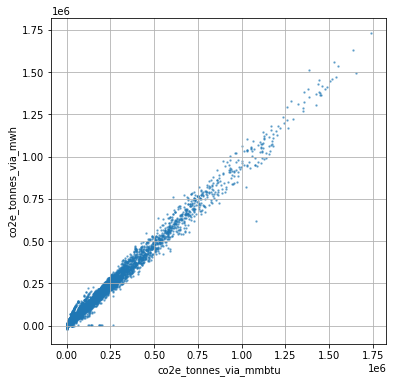

In [159]:
co2_cc.plot.scatter(x='co2e_tonnes_via_mmbtu', y='co2e_tonnes_via_mwh', s=2, alpha=0.5, figsize=(6,6), grid=True)

In [161]:
co2_cc[['co2e_tonnes_via_mmbtu','co2e_tonnes_via_mwh']].isna().sum()

co2e_tonnes_via_mmbtu    0
co2e_tonnes_via_mwh      0
dtype: int64

In [163]:
# use mmbtu calc unless it is zero, in which case use the max estimate.
co2_cc['co2e_tonnes_per_year'] = co2_cc.loc[:, 'co2e_tonnes_via_mmbtu'].where(co2_cc.loc[:, 'co2e_tonnes_via_mmbtu'].gt(0), other=co2_cc.loc[:, ['co2e_tonnes_via_mmbtu', 'co2e_tonnes_via_mwh']].max(axis=1))

In [164]:
plant_co2 = co2_cc.groupby('plant_id_eia')['co2e_tonnes_per_year'].sum()
plant_co2

plant_id_eia
3        5.466142e+06
7        3.325334e+04
9        3.532316e+04
10       6.252257e+05
26       3.219624e+06
             ...     
64663    8.489600e+00
64748    1.929792e+02
64749    9.153911e+02
64753    3.215118e+03
64756    3.426721e+03
Name: co2e_tonnes_per_year, Length: 3323, dtype: float64

In [165]:
plant_co2.describe()

count    3.323000e+03
mean     4.379642e+05
std      1.313895e+06
min      0.000000e+00
25%      1.638214e+02
50%      7.688322e+03
75%      1.481230e+05
max      1.662465e+07
Name: co2e_tonnes_per_year, dtype: float64

<AxesSubplot:>

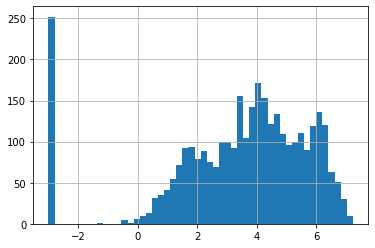

In [171]:
plant_co2.replace(0, 1e-3).transform(np.log10).hist(bins=50)